For this code, need to use python 3 kernel and not LELEC210X kernel!

https://www.tensorflow.org/tutorials/audio/simple_audio
https://github.com/nicknochnack/ImageClassification/blob/main/Getting%20Started.ipynb
https://nmbu.brage.unit.no/nmbu-xmlui/bitstream/handle/11250/2611624/report-print1.pdf?sequence=3&isAllowed=y


In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt

"Machine learning tools"
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.decomposition import PCA
import pickle
from pathlib import Path
from typing import List, Tuple
import glob

from classification.datasets import Dataset

from classification.utils.plots import plot_specgram, show_confusion_matrix, plot_decision_boundaries
from classification.utils.utils import accuracy
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [21]:
#!pip install --upgrade pip # update pip if needed

In [22]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [23]:
#pip install scikeras

In [24]:
#!pip list

In [25]:
model_dir = "../goldenProject/python/modelCNN/"
fv_dir = "../goldenProject/python/bigDataset/"

<font size=5 color=#009999> 1. Our dataset </font> <br>

<font size=4 color=#009999> 1.1 Build matrix of fv </font> <br>

In [26]:
def get_cls_from_path(file):
    return file.stem.split("_", maxsplit=1)[0]


format = "pickle"
classnames = ['birds','chainsaw','fire','handsaw','helicopter']

#fv = pickle.load(open(fv_dir + filename, 'rb'))
#print(fv)
#print(fv.shape)

dic_fv = {}
for file in sorted((Path(fv_dir)).glob("**/*." + format)):
    #print(str(file))
    fv = pickle.load(open(file, 'rb'))
    fv = np.squeeze(fv)
    cls = get_cls_from_path(file)
    #print(cls)
    dic_fv.setdefault(cls, []).append(fv)
print(dic_fv)

nclass = len(dic_fv)
naudio = len(dic_fv[list(dic_fv.keys())[0]])
size = nclass * naudio

print(nclass)
print(naudio)
print(size)

# plt.figure()
# plot_specgram(fv.reshape((20, 20)).T, ax=plt.gca(), is_mel=True, title="MEL Spectrogram", xlabel="Mel vector")
# plt.show()


{'birds': [array([ 2,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  2,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  3,  2,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  2,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  4,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  1,  0,  0,  0,  2,  2,
        2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  5,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        6,  0,  0,  0,  0,  0,  0,  4,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 10,  1,  0,  0,  0,  0,  0,  2,  2,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  5,  7,  0,  0,  0,  0,  0,  0,  2,  3,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  2,  3,  0,  0,  0,  0,  0,  0,  3,
        0,  0,

In [27]:
### Features vectors build matrix ###

train_pct = 0.7
print(len(dic_fv["birds"][0]))
featveclen = len(dic_fv["birds"][0]) # number of items in a feature vector
#nitems = size
nlearn = round(naudio * train_pct) # number of sounds among naudio for training
fm_dir = "data/feature_matrices2/"

data_aug_factor = 1
class_ids_aug = np.repeat(classnames, naudio*data_aug_factor) #matrice avec les noms des classes x le nombre de sons (40 de base)

X = np.zeros((data_aug_factor*size, featveclen)) #nombre de sons total x taille du feature vector
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio):
            featvec = dic_fv[classname][idx] #melspec
            X[s*nclass*naudio+class_idx*naudio+idx,:] = featvec       
#np.save(fm_dir+"feature_matrix_2D_Bby.npy", X)


400


In [28]:
#X = np.load(fm_dir+"feature_matrix_2D_Bby.npy")

# "Labels"
y = class_ids_aug.copy() #noms des sons

print('Shape of the feature matrix : {}'.format(X.shape))
print('Number of labels : {}'.format(len(y)))

print()

Shape of the feature matrix : (1000, 400)
Number of labels : 1000



<font size=4 color=#009999> 1.3 Build data and split it </font> <br>

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y) # random_state=1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1)

nbre_nan = np.count_nonzero(np.isnan(X_train))
print("Nombre de NaN dans la matrice :", nbre_nan)

print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", y_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of Y_val: ", y_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", y_test.shape)

Nombre de NaN dans la matrice : 0
Shape of X_train:  (810, 400)
Shape of Y_train:  (810,)
Shape of X_val:  (90, 400)
Shape of Y_val:  (90,)
Shape of X_test:  (100, 400)
Shape of Y_test:  (100,)


In [30]:
# [2] (optional) Data normalization
X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_val = X_val / np.linalg.norm(X_val, axis=1, keepdims=True)
X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)


#  reshape by N_Melvec x Melvec_length x 1
X_train = X_train.reshape(len(X_train), 20, 20, 1)
y_train = y_train.reshape(len(y_train),)

X_val = X_val.reshape(len(X_val), 20, 20, 1)
y_val = y_val.reshape(len(y_val),)

X_test = X_test.reshape(len(X_test), 20, 20, 1)
y_test = y_test.reshape(len(y_test),)


print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", y_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of Y_val: ", y_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", y_test.shape)

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train) # Reshape labels to (n_samples,)
y_val_encoded = label_encoder.fit_transform(y_val) # Reshape labels to (n_samples,)

Shape of X_train:  (810, 20, 20, 1)
Shape of Y_train:  (810,)
Shape of X_val:  (90, 20, 20, 1)
Shape of Y_val:  (90,)
Shape of X_test:  (100, 20, 20, 1)
Shape of Y_test:  (100,)


In [31]:
# [3] (optional) dimensionality reduction.

In [32]:
# [4] Model training and selection
def create_model():
    input_shape = (20, 20, 1)
    num_labels = 5

    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_labels, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model with KerasClassifier
keras_model = KerasClassifier(model=create_model, verbose=0)

# Define the parameter grid
param_grid = {
    'batch_size': [8, 16, 24, 32, 64],
    'epochs': [10, 20, 30, 40, 50],
    # Add other parameters to search over if needed
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train_encoded)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)


# Create lists to store parameters and corresponding scores
batch_sizes = param_grid['batch_size']
epochs = param_grid['epochs']

Best parameters found:  {'batch_size': 8, 'epochs': 50}
Best accuracy found:  0.9209876543209877


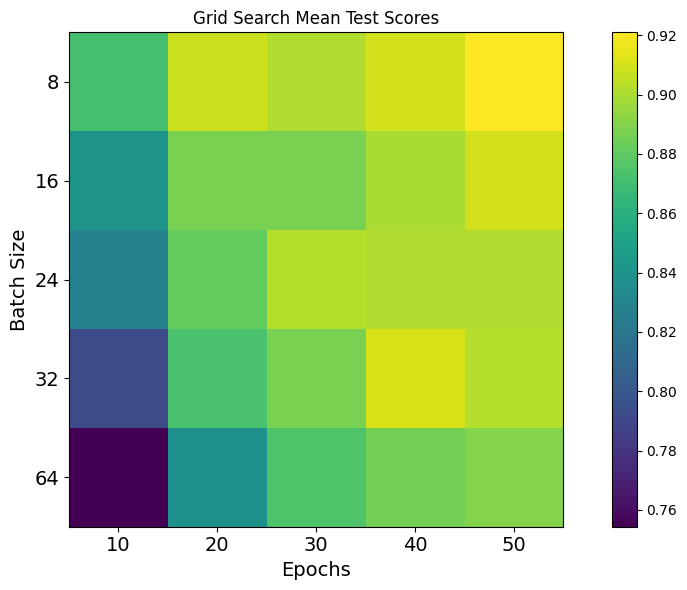

In [33]:
results = grid_search.cv_results_

# Extract mean test scores
mean_test_scores = np.array(results['mean_test_score']).reshape(len(param_grid['batch_size']), len(param_grid['epochs']))

# Plot heatmap
plt.figure(figsize=(10, 6))
plt.imshow(mean_test_scores, interpolation='nearest', cmap='viridis')
plt.title('Grid Search Mean Test Scores')
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Batch Size',fontsize=14)
plt.colorbar()
plt.xticks(np.arange(len(param_grid['epochs'])), param_grid['epochs'],fontsize=14)
plt.yticks(np.arange(len(param_grid['batch_size'])), param_grid['batch_size'],fontsize=14)
plt.tight_layout()
plt.savefig('gridSearchScores.pdf')
plt.show()


In [39]:
from keras.layers import Dropout

# Update the param_grid
param_grid = {
    'dropout_rate': [0, 0.1, 0.2],
    'optimizer': ['adam', 'rmsprop']
}

# Define the updated create_model function with dropout_rate and optimizer as parameters
def create_model2(dropout_rate=0, optimizer='adam'):
    input_shape = (20, 20, 1)
    num_labels = 5

    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout layer
    model.add(Dense(num_labels, activation='softmax'))

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model with KerasClassifier
keras_model = KerasClassifier(model=create_model2, verbose=0)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train_encoded)

# Print best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

ValueError: Invalid parameter dropout_rate for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(dropout_rate=0)`
Check the list of available parameters with `estimator.get_params().keys()`